## Classifying tick bites using data from agent based modelling

## Load Libraries

In [4]:
# Step 1: Import Required Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Load data generated by ABM model from previous step

In [2]:
# Step 2: Load the Data
PATH = "~/Documents/ITC/github/abm/data/outputs/csv"
# PATH = "./"
DATA_FILEPATH = os.path.join(PATH, "agent-output.csv")
df = pd.read_csv(DATA_FILEPATH)

## Data Description

### Features generated from ABM

| Feature         | Type        | Description                                                                       |
| --------------- | ----------- | --------------------------------------------------------------------------------- |
| `tick`          | Numerical   | Time index (e.g., days since simulation start or a running timestamp)             |
| `agent-type`    | Categorical | Type of agent (e.g., `adult`, `child`, `senior`, `tourist-adult`, etc.)           |
| `activity`      | Categorical | Type of activity (e.g., `1`: Gardening, `2`: Playing, `3`: Walking, `4`: Indoors) |
| `bite-stat`     | Binary      | Whether the agent received a tick bite (`True` or `False`)                        |
| `patch-landuse` | Categorical | Land use code of the patch where the agent is located (e.g., `20`, `60`, `61` & `62`.)    |

### Summary Statistics

In [84]:
# renaming activity codes to activity names
activity_map = {
    1: "Gardening",
    2: "Playing",
    3: "Walking",
    4: "Indoors"
}
df["activity"] = df["activity"].replace(activity_map)

# renaming landuse code to landuse names
landuse_map = {
    20: "Residential",
    60: "Forest",
    61: "Sand Dunes",
    62: "Farms"
}
df["patch-landuse"] = df["patch-landuse"].replace(landuse_map)

# Summary statistics for numerical + binary
summary_numeric = df[["tick", "bite-stat"]].describe()

# Value counts for categorical features
agent_counts = df["agent-type"].value_counts()
activity_counts = df["activity"].value_counts()
landuse_counts = df["patch-landuse"].value_counts()

# Value counts for bite-stat
bite_status = df["bite-stat"].value_counts()

# Combine all
print("Numeric Summary:\n", summary_numeric, "\n")
print("Agent Type Distribution:\n", agent_counts, "\n")
print("Activity Distribution:\n", activity_counts, "\n")
print("Patch Landuse Distribution:\n", landuse_counts)
print("Bite Status Distribution:\n", bite_status)
print("Bite Status Based on Landuse & Activity")
print(df.groupby(["agent-type", "activity", "patch-landuse"])["bite-stat"].value_counts())

Numeric Summary:
                tick
count  42940.000000
mean     186.924779
std       93.925553
min        0.000000
25%      119.000000
50%      192.500000
75%      249.000000
max      365.000000 

Agent Type Distribution:
 agent-type
adult             21960
senior             7320
tourist-adult      6000
child              3660
tourist-senior     2000
tourist-child      2000
Name: count, dtype: int64 

Activity Distribution:
 activity
Indoors      12180
Playing      10386
Walking      10189
Gardening    10185
Name: count, dtype: int64 

Patch Landuse Distribution:
 patch-landuse
Farms          14761
Forest         14241
Residential    12180
Sand Dunes      1758
Name: count, dtype: int64
Bite Status Distribution:
 bite-stat
False    38450
True      4490
Name: count, dtype: int64
Bite Status Based on Landuse & Activity
agent-type      activity   patch-landuse  bite-stat
adult           Gardening  Farms          False        1831
                                          True          

### Interpretation

#### Agent Type Distribution

The dataset contains a total of 42,600 agent records, composed of both residents and tourists. Adults form the largest group, followed by seniors and children. Tourists are evenly split across adults, seniors, and children

- Adult: 21,960

- Senior: 7,320

- Tourist-Adult: 6,000

- Child: 3,660

- Tourist-Senior: 2,000

- Tourist-Child: 2,000

This distribution reflects a higher representation of adult agents, which is expected given their population proportion and more consistent outdoor presence.

#### Activity Distribution

Agents perform one of four activities each day. The frequency is relatively balanced across all activities, with Indoors being the most common:

- Indoors: 12,180

- Playing: 10,386

- Walking: 10,189

- Gardening: 10,185

This balance ensures all activity types are represented when modeling exposure to tick habitats.

#### Patch Land Use Distribution

Agents move across different land use types, which influence their exposure risk. Most interactions occur in Farms and Forests, where tick presence is typically higher:

- Farms: 14,761

- Forest: 14,241

- Residential: 12,180

- Sand Dunes: 1,758

This spatial variation helps the model learn environmental risk factors associated with land use.

#### Tick Bite Outcome Distribution

Tick bite cases are imbalanced, with a relatively low bite incidence rate:

- No Bite (False): 38,450 (~90%)

- Bite (True): 4,490 (~10%)

This imbalance was addressed during model development through balancing techniques such as stratified undersampling.

## Feature Engineering and Dataset Preparation

1. **Addressing Class Imbalance**
   Implemented stratified undersampling to ensure balanced representation of the `bite-stat` across combinations of key categorical features.

2. **Temporal Features**
   Derived new features based on the `tick` (representing date or day):

   * `is_weekday`: True if the day is Monday to Friday, otherwise False.
   * `is_student_vacation`: True if the date falls within known school holiday periods.
   * `is_adult_vacation`: True if the date corresponds to common adult vacation windows.

3. **Agent Categorization**
   Transformed the `agent-type` column:

   * Created a simplified `agent` feature with values: `child`, `adult`, and `senior`.
   * Introduced a boolean feature `is_local` to distinguish between residents (`True`) and tourists (`False`).

4. **Weather Features**
   Merged external temperature and precipitation data into the dataset based on `tick` to capture environmental context influencing tick activity.

5. **Encoding Categorical Variables**
   Applied one-hot encoding to categorical features: `activity`, `patch-landuse`, and `agent` to prepare the data for machine learning models.

6. **Correlation Analysis**
   Plotted a correlation matrix for numerical features to inspect linear relationships and assess multicollinearity.


#### Step 1: Balance the dataset

In [90]:
# Separate by class
df_minority = df[df['bite-stat'] == True]
df_majority = df[df['bite-stat'] == False]

# Count of minority class
minority_count = len(df_minority)

# Create group labels
group_cols = ['agent-type'] # 'patch-landuse' ,'activity' 
df_majority['group_key'] = df_majority[group_cols].astype(str).agg('_'.join, axis=1)
df_minority['group_key'] = df_minority[group_cols].astype(str).agg('_'.join, axis=1)

# Get group frequencies in minority to mirror in majority
group_counts = df_minority['group_key'].value_counts()

# Now undersample the majority to match minority group distribution
df_majority_balanced = pd.concat([
    df_majority[df_majority['group_key'] == gk].sample(n=min(len(df_majority[df_majority['group_key'] == gk]), count), random_state=42)
    for gk, count in group_counts.items()
])

# Combine back the two classes
df_balanced = pd.concat([df_minority, df_majority_balanced]).drop(columns='group_key')
print(df_balanced.groupby(["activity", "patch-landuse"])["bite-stat"].value_counts())

activity   patch-landuse  bite-stat
Gardening  Farms          True          578
                          False         545
           Forest         True          604
                          False         483
Indoors    Residential    False        1304
                          True          638
Playing    Farms          True          547
                          False         478
           Forest         True          490
                          False         472
           Sand Dunes     False         195
                          True          120
Walking    Farms          True          749
                          False         523
           Forest         True          764
                          False         490
Name: count, dtype: int64


/tmp/ipykernel_21401/2695414753.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_majority['group_key'] = df_majority[group_cols].astype(str).agg('_'.join, axis=1)
/tmp/ipykernel_21401/2695414753.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minority['group_key'] = df_minority[group_cols].astype(str).agg('_'.join, axis=1)


#### Step 2: `is_weekday` OR `is_weekend`, `is_student_vacation`, `is_adult_vacation` based on time (tick).

In [91]:
df = df_balanced.copy()

# Weekday and Weekend
df["is_weekday"] = ~df["tick"].mod(7).isin([6, 0])
df["is_weekday"] = df["is_weekday"].astype("int")

# Student Vacation Logic
df["is_student_vacation"] = (
    ((df["tick"] >= 300) & (df["tick"] <= 307)) |  # Oct 26 – Nov 3
    ((df["tick"] >= 356) | (df["tick"] <= 5))   |  # Dec 21 – Jan 5
    ((df["tick"] >= 53)  & (df["tick"] <= 61))  |  # Feb 22 – Mar 2
    ((df["tick"] >= 117) & (df["tick"] <= 125)) |  # Apr 26 – May 4
    ((df["tick"] >= 200) & (df["tick"] <= 243))    # Jul 19 – Aug 31
)

df["is_student_vacation"] = df["is_student_vacation"].astype("int")

# Adult Vacation Logic
df["is_adult_vacation"] = (df["tick"] >= 200) & (df["tick"] <= 219)
df["is_adult_vacation"] = df["is_adult_vacation"].astype("int")

#### Step 3: Derive `agent` and `is_local` columns

In [93]:
# Step 3: Derive 'agent' and 'is_local' columns
df["agent"] = df["agent-type"].str.replace("tourist-", "", regex=False)
df["is_local"] = df["agent-type"].apply(lambda x: 0 if "tourist" in x else 1)

#### Step 4: Add temperature & precipitation to the dataset based on tick.

In [94]:
# Step 4: Add temperature & precipitation to the dataset based on tick. 
df_weather = pd.read_csv("/home/saheel/Documents/ITC/github/abm/data/ede_precipitation.csv", header=None)
df_weather.rename({0: "precipitation", 1: "temperature"}, axis=1, inplace=True)

# First, reset index to make 'tick' a column in weather DataFrames
df_weather = df_weather.reset_index().rename(columns={'index': 'tick'})

# Now merge this weather data with main tick-bite df on 'tick'
df_merged = pd.merge(df, df_weather, on='tick', how='left')

#### Step 5: Encode categorical features

In [95]:
df_encoded = pd.get_dummies(df_merged, columns=['agent', 'patch-landuse', 'activity'])
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

#### Step 6: Plot correlation chart

In [96]:
# df_encoded.drop(["patch-landuse_Residential", "activity_Indoors"], axis=1, inplace=True)

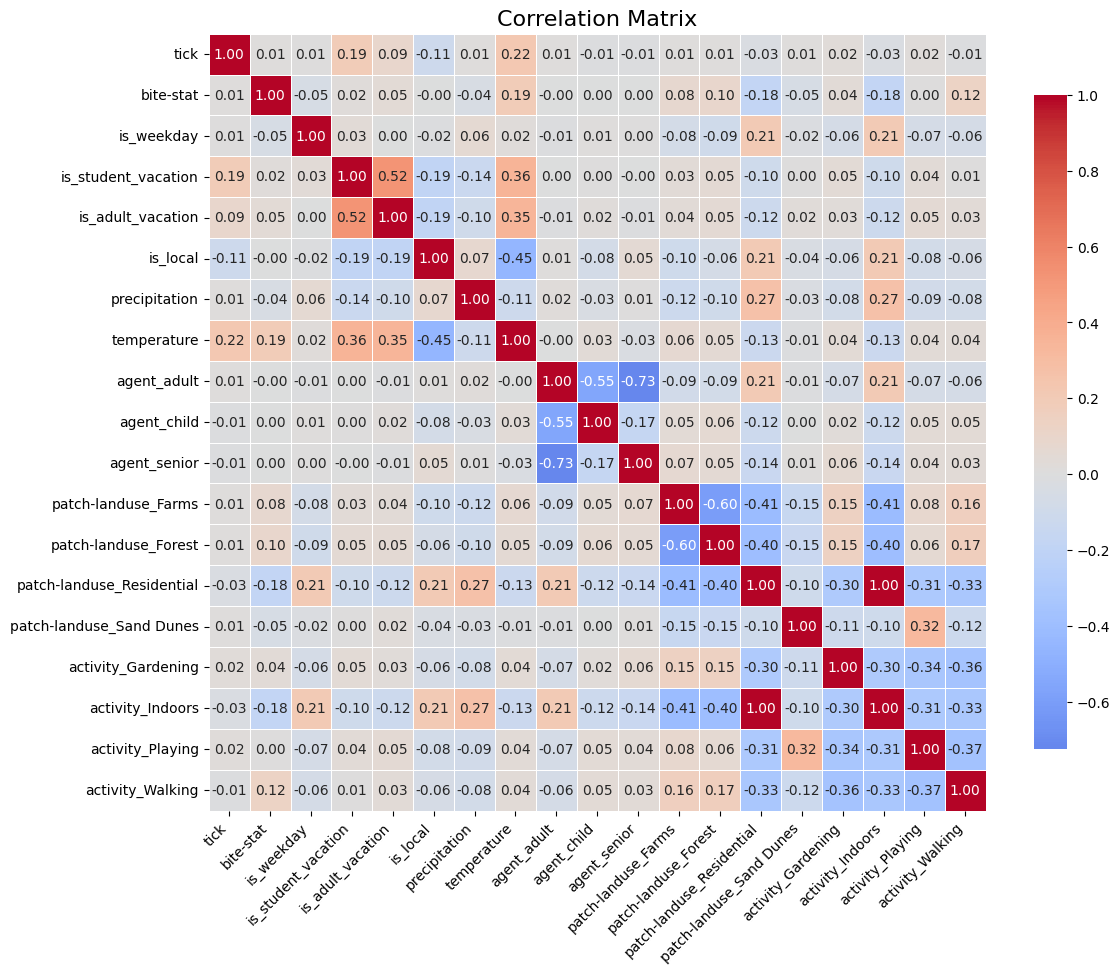

In [97]:
# Optionally filter numeric columns only
df_numeric = df_encoded.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

# Add title
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## ML Implementation

In [98]:
df_encoded.shape

(8980, 20)

In [99]:
# Seperate features & label
X = df_encoded.drop(columns=['bite-stat', 'tick', 'agent-type'])
y = df_encoded['bite-stat'].astype(int)

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# Create Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Generate prediction on test set
y_pred = rf.predict(X_test)

### Model Evaluation

Classification Report: After On Hot Encoding
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       898
           1       0.59      0.59      0.59       898

    accuracy                           0.59      1796
   macro avg       0.59      0.59      0.59      1796
weighted avg       0.59      0.59      0.59      1796



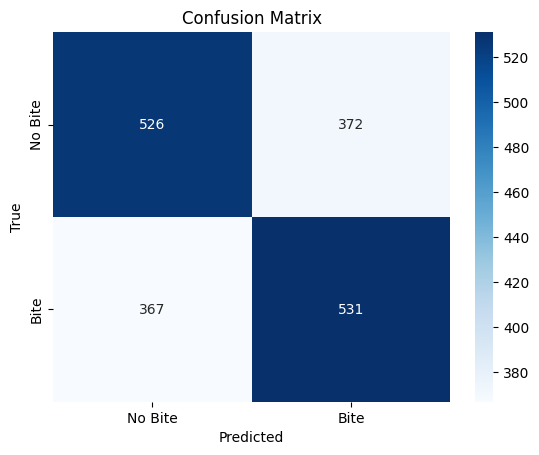

In [100]:
# Step 8: Evaluate Performance
print("Classification Report: After On Hot Encoding")
print(classification_report(y_test, y_pred))

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Bite", "Bite"], yticklabels=["No Bite", "Bite"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The classification report shows that the model performs equally across both classes (tick bite = 0 and tick bite = 1) with a balanced dataset

Accuracy: 0.59
This means the model correctly classifies 59% of the total cases implying it's good there is clear room for improvement.

Precision and Recall:

- Class 0 (No Bite): Precision = 0.59, Recall = 0.59

- Class 1 (Bite): Precision = 0.59, Recall = 0.59
    
The identical scores across both classes suggest that the model does not favor one class over another, indicating fair balance after resampling.

F1-Score: 0.59 for both classes
The F1-score, which balances precision and recall, also remains consistent across the two classes. This reinforces that the model is not biased but also not especially accurate

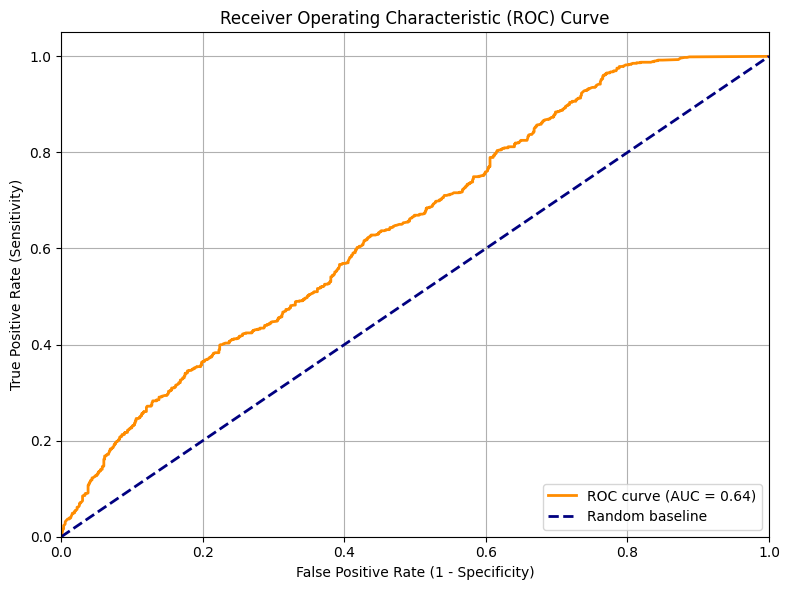

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1)
y_prob = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC (Reciever Operator Characteristics) curve visualises the trade off between the The True Positive Rate (Sensitivity) and False Positive Rate for our tick bite classification model. Our model achieved an AUC (area under curve) score of 0.64. An AUC score of 0.5 is generally a reference score, 0.64 shows moderately discriminatory ability with still room for improvement. In other words model can distinguish between a tick bite and non-bite case 64% of the time, which is useful but leaves considerable room for improvement.

### Feature Importance

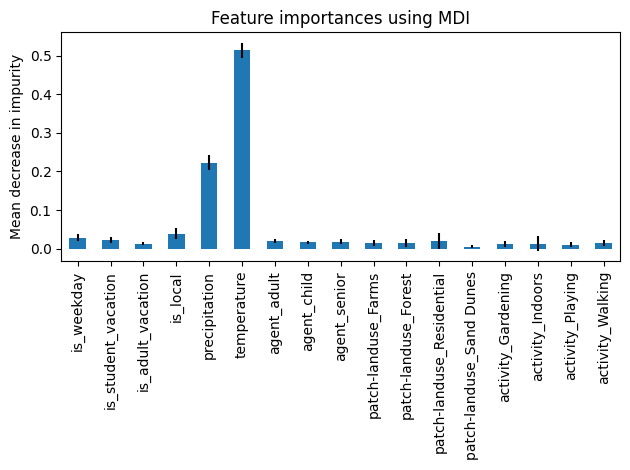

In [102]:
feature_names = X_train.columns #[f"feature {i}" for i in range(X_train.shape[1])]

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Analysis of feature importance reveals that temperature and precipitation are the dominant predictors in the tick bite classification model. Their high contribution suggests that the model has effectively learned seasonal patterns, as tick activity is closely tied to climatic conditions. Warmer, wetter months likely correspond to higher tick presence and activity, which the model captures through these environmental variables.

Additionally, the is_local feature—differentiating residents from tourists—also plays a meaningful role. This distinction aligns with behavioral patterns:

1. Tourists tend to appear predominantly during vacation periods, leading to higher bite reports during concentrated seasonal windows.

2. Residents, on the other hand, are present year-round, engaging in a wider range of activities and land uses, adding diversity to the data.

### Deep Dive into misclassification & justification

In [ ]:
# Ensure y_test and y_pred are Series with the same index as X_test
y_test = pd.Series(y_test, index=X_test.index, name='true_label')
y_pred = pd.Series(y_pred, index=X_test.index, name='predicted_label')

# Concatenate all together
df_results = pd.concat([X_test, y_test, y_pred], axis=1)

# Preview
print(df_results.head())

# Decode activity # "activity_4"
df_results["activity"] = df_results[[col for col in df_results.columns if col.startswith("activity_")]].idxmax(axis=1).str.replace("activity_", "")

# Decode landuse # "patch-landuse_20"
df_results["patch-landuse"] = df_results[
    [col for col in df_results.columns if col.startswith("patch-landuse_")]
].idxmax(axis=1).str.replace("patch-landuse_", "")

# Decode agent
df_results["agent"] = df_results[
    ["agent_adult", "agent_child", "agent_senior"]
].idxmax(axis=1).str.replace("agent_", "")


false_positive = df_results[(df_results["true_label"]==0) & (df_results["predicted_label"]==1)]

false_negative = df_results[(df_results["true_label"]==1) & (df_results["predicted_label"]==0)]

/tmp/ipykernel_21401/2172905596.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positive["group"] = false_positive["activity"].astype(str) + " | " + \
/tmp/ipykernel_21401/2172905596.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negative["group"] = false_negative["activity"].astype(str) + " | " + \


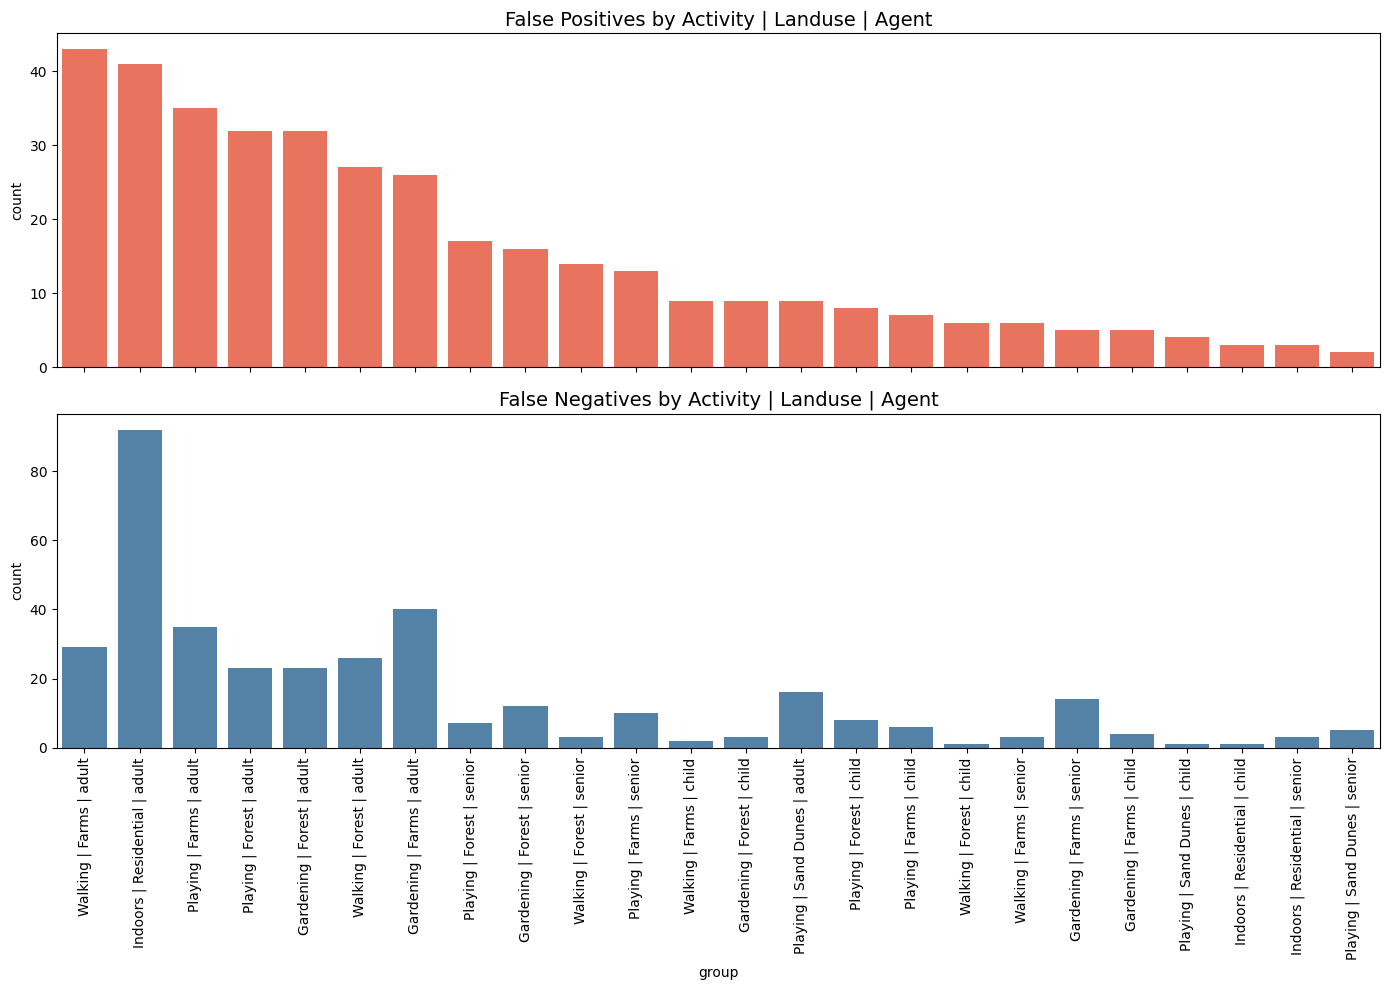

In [ ]:
# Create a combined feature for plotting
false_positive["group"] = false_positive["activity"].astype(str) + " | " + \
                          false_positive["patch-landuse"].astype(str) + " | " + \
                          false_positive["agent"].astype(str)

false_negative["group"] = false_negative["activity"].astype(str) + " | " + \
                          false_negative["patch-landuse"].astype(str) + " | " + \
                          false_negative["agent"].astype(str)

# Count occurrences
fp_counts = false_positive["group"].value_counts().reset_index()
fp_counts.columns = ["group", "count"]

fn_counts = false_negative["group"].value_counts().reset_index()
fn_counts.columns = ["group", "count"]

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.barplot(data=fp_counts, x="group", y="count", ax=ax[0], color='tomato')
ax[0].set_title("False Positives by Activity | Landuse | Agent", fontsize=14)
ax[0].tick_params(axis='x', rotation=90)

sns.barplot(data=fn_counts, x="group", y="count", ax=ax[1], color='steelblue')
ax[1].set_title("False Negatives by Activity | Landuse | Agent", fontsize=14)
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


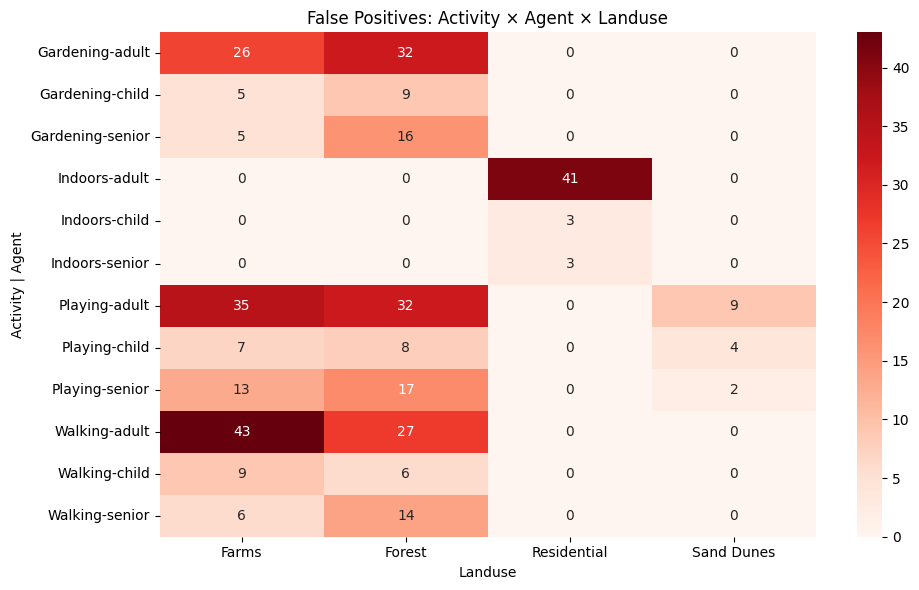

In [105]:
# Crosstab (False Positives)
fp_matrix = pd.crosstab(
    [false_positive["activity"], false_positive["agent"]],
    false_positive["patch-landuse"]
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fp_matrix, annot=True, fmt='d', cmap="Reds")
plt.title("False Positives: Activity × Agent × Landuse")
plt.ylabel("Activity | Agent")
plt.xlabel("Landuse")
plt.tight_layout()
plt.show()

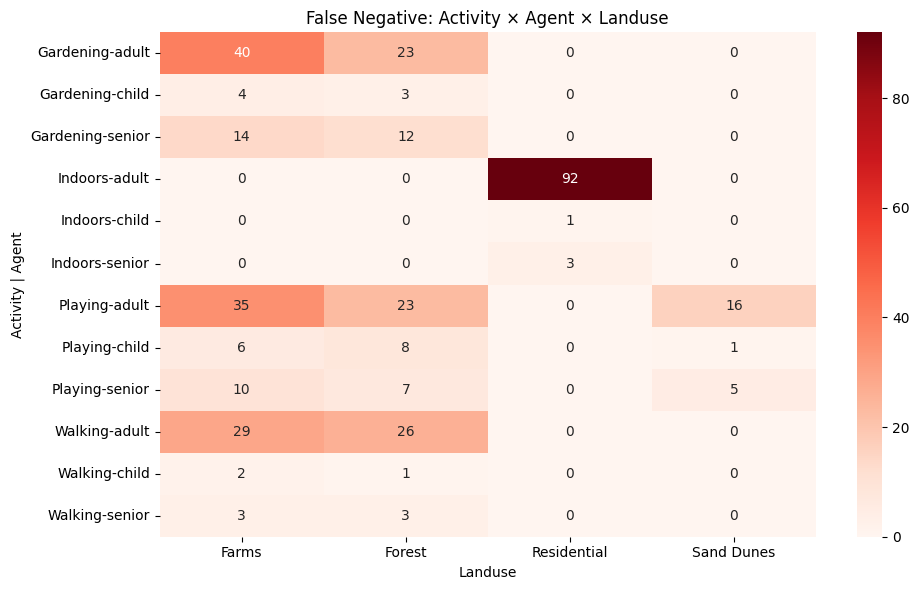

In [106]:
# Crosstab (False Negative)
fp_matrix = pd.crosstab(
    [false_negative["activity"], false_negative["agent"]],
    false_negative["patch-landuse"]
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fp_matrix, annot=True, fmt='d', cmap="Reds")
plt.title("False Negative: Activity × Agent × Landuse")
plt.ylabel("Activity | Agent")
plt.xlabel("Landuse")
plt.tight_layout()
plt.show()

### Misclassification Analysis Summary

**False Negatives (FN)**

These are actual tick bite cases that the model failed to identify.

Key Observations

1. Indoors-Adult in Residential areas shows the highest FN (92 cases) — indicating underprediction in low-risk looking conditions.

2. Walking-Adult and Playing-Adult in Farms and Forest also have a high number of FNs (≈ 20–35 each), possibly because the model underestimates exposure in outdoor scenarios for adults.

3. Gardening-Adult in Farms and Forest and Gardening-Senior also show noticeable FN counts.

**False Positives (FP)**

These are predicted tick bite cases where there were actually no bites.

Key Observations:

1. Again, Indoors-Adult in Residential leads FP (41 cases), showing confusion between actual and perceived risk in indoor settings.

2. Playing-Adult and Walking-Adult in Farms and Forest have high FP rates, possibly due to overlapping features with true bite cases.

3. Gardening-Adult in Forest is another hot spot.

Justification:

#### Residential + Indoors Bias in Simulation

In the Agent-Based Model (ABM) simulation, residents in residential areas performing indoor activities are generally considered low-risk for tick bites, which aligns with real-world expectations. However, to introduce realism, a rare-event bias was deliberately included: ticks could occasionally be brought indoors by pets, clothes, or other indirect means. Despite this simulation detail, the machine learning model struggles to learn this pattern, as reflected in:

- False negatives where indoor-resident tick bites were not predicted.
- Low feature importance or absence of strong signals linking indoor activity and residential land use to positive bite events.

This gap is expected: the rarity of these events makes them statistically weak, and tree-based models like Random Forest may underfit such minority edge cases unless explicitly engineered.

#### High False Positive Rates in Farms & Forests: A Ground Truth Perspective

From the analysis of misclassifications:

- Farms and Forests consistently show higher false positive rates.

- This means the model often predicts a tick bite where none occurred in the data.

However, this is not necessarily a model error — rather, it's a reflection of real-world risk: Field surveys and ecological studies consistently highlight farms and forests as high-risk environments for tick exposure due to: Dense vegetation, Presence of wildlife hosts (e.g., deer, rodents), Humid, shaded microclimates that ticks thrive in. The model, learning from patterns in the dataset, appears to overcompensate for this environmental risk — potentially due to lack of fine-grained ecological or behavioral context (e.g., duration of activity, specific locations within land use types)

## Prediction on Ground Truth data (NL Tick Bites Survey) (Only positive tick bite cases)

In [108]:
with open('model_rf_item1.pkl', 'wb') as f:
    cPickle.dump(rf, f)

In [5]:
import _pickle as cPickle
import os

MODEL_PATH = "model_rf_item1.pkl"
with open(MODEL_PATH, 'rb') as f:
    rf_model = cPickle.load(f)

In [6]:
GROUND_TRUTH_FILEPATH = "/home/saheel/Documents/ITC/github/abm/machine-learning/data/"
VALIDATION_FILENAME = os.path.join(GROUND_TRUTH_FILEPATH, "ground-truth-tick-reports.csv")
df_validation_set = pd.read_csv(VALIDATION_FILENAME)
df_validation_set.head()

,reporting_date,latitude,longitude,age_at_bite,activity_grouped,BG2015,agent-type
0,2006-04-09,173000.0,451000.0,38.0,Walking,20,Adult
1,2006-04-23,173000.0,451000.0,39.0,Walking,20,Adult
2,2006-05-04,173000.0,451000.0,6.0,Other,20,Child
3,2006-06-03,173000.0,451000.0,49.0,Gardening,20,Adult
4,2006-06-06,173000.0,451000.0,20.0,Playing,20,Adult


In [8]:
import pandas as pd

# --- Step 1: Preprocess Dates ---
df_validation_set["date"] = pd.to_datetime(df_validation_set["reporting_date"])
df_validation_set["tick"] = df_validation_set["date"].dt.day_of_year
df_validation_set["is_weekday"] = (~df_validation_set["date"].dt.dayofweek.isin([5, 6])).astype(int)

# Extract month and day for rule-based vacation logic
df_validation_set["month"] = df_validation_set["date"].dt.month
df_validation_set["day"] = df_validation_set["date"].dt.day

# --- Step 2: Define Vacation Windows ---
# Student vacation windows (approximate Dutch school calendar)
student_vacation_conditions = (
    ((df_validation_set["month"] == 12) & (df_validation_set["day"] >= 20)) |
    ((df_validation_set["month"] == 1)  & (df_validation_set["day"] <= 6))  |
    ((df_validation_set["month"] == 2)  & (df_validation_set["day"] >= 20)) |
    ((df_validation_set["month"] == 3)  & (df_validation_set["day"] <= 5))  |
    ((df_validation_set["month"] == 4)  & (df_validation_set["day"] >= 25)) |
    ((df_validation_set["month"] == 5)  & (df_validation_set["day"] <= 5))  |
    ((df_validation_set["month"] == 7)  & (df_validation_set["day"] >= 15)) |
    (df_validation_set["month"] == 8)                                     |
    ((df_validation_set["month"] == 10) & (df_validation_set["day"] >= 15)) |
    ((df_validation_set["month"] == 11) & (df_validation_set["day"] <= 5))
)
df_validation_set["is_student_vacation"] = student_vacation_conditions.astype(int)

# Adult vacation window: July 19 – August 7
adult_vacation_conditions = (
    ((df_validation_set["month"] == 7) & (df_validation_set["day"] >= 19)) |
    ((df_validation_set["month"] == 8) & (df_validation_set["day"] <= 7))
)
df_validation_set["is_adult_vacation"] = adult_vacation_conditions.astype(int)

# Drop temporary month and day columns
df_validation_set.drop(columns=["month", "day"], inplace=True)

# --- Step 3: Clean & Rename Columns ---
df_validation_set.rename(columns={
    "activity_grouped": "activity",
    "BG2015": "patch-landuse"
}, inplace=True)


# Map numeric landuse codes to labels
landuse_map = {
    20: "Residential",
    60: "Forest",
    61: "Sand Dunes",
    62: "Farms"
}
df_validation_set["patch-landuse"] = df_validation_set["patch-landuse"].map(landuse_map)

# Standardize agent names to lowercase
df_validation_set["agent"] = df_validation_set["agent-type"].str.lower()

# Bite status is always positive in validation
df_validation_set["bite-stat"] = 1

# Replace "Other" activity with activities based on landuse
# Define conditions for remapping "Other" activity
conditions = [
    (df_validation_set["activity"] == "Other") & df_validation_set["patch-landuse"].isin(["Forest", "Farms"]),
    (df_validation_set["activity"] == "Other") & df_validation_set["patch-landuse"].isin(["Forest", "Sand Dunes", "Farms"]),
    (df_validation_set["activity"] == "Other") & df_validation_set["patch-landuse"].isin(["Forest", "Farms"]),
    (df_validation_set["activity"] == "Other") & (df_validation_set["patch-landuse"] == "Residential")
]

# Corresponding activities based on your logic
values = ["Gardening", "Playing", "Walking", "Indoors"]

# Apply logic
df_validation_set["activity"] = np.select(conditions, values, default=df_validation_set["activity"])

# --- Step 4: Merge with Weather Data ---
df_weather = pd.read_csv("/home/saheel/Documents/ITC/github/abm/data/ede_precipitation.csv", header=None)
df_weather = df_weather.rename(columns={0: "precipitation", 1: "temperature"})
df_weather = df_weather.reset_index().rename(columns={"index": "tick"})

# Merge on tick
df_merged_val = pd.merge(df_validation_set, df_weather, on="tick", how="left")

# Local = 1 for validation data
df_merged_val["is_local"] = 1

# --- Step 5: Encode Categorical Features ---
df_encoded = pd.get_dummies(df_merged_val, columns=["agent", "patch-landuse", "activity"])

# Final cleanup
df_encoded.drop(columns=["date", "tick", "agent-type", "reporting_date", "latitude", "longitude", "age_at_bite"], inplace=True)

# df_encoded is now ready for prediction

In [9]:
df_validation_set.groupby("activity").size(), df_validation_set.groupby("patch-landuse").size() 

(activity
 Gardening    338
 Indoors       50
 Playing      155
 Walking      561
 dtype: int64,
 patch-landuse
 Farms          287
 Forest         429
 Residential    238
 Sand Dunes     150
 dtype: int64)

In [10]:
df_encoded.columns

Index(['is_weekday', 'is_student_vacation', 'is_adult_vacation', 'bite-stat',
       'precipitation', 'temperature', 'is_local', 'agent_adult',
       'agent_child', 'agent_senior', 'patch-landuse_Farms',
       'patch-landuse_Forest', 'patch-landuse_Residential',
       'patch-landuse_Sand Dunes', 'activity_Gardening', 'activity_Indoors',
       'activity_Playing', 'activity_Walking'],
      dtype='object')

In [34]:
FEATURES = ['is_weekday', 'is_student_vacation', 'is_adult_vacation', 'is_local',
       'precipitation', 'temperature', 'agent_adult', 'agent_child',
       'agent_senior', 'patch-landuse_Farms', 'patch-landuse_Forest',
       'patch-landuse_Residential', 'patch-landuse_Sand Dunes',
       'activity_Gardening', 'activity_Indoors', 'activity_Playing',
       'activity_Walking']

y_pred_holdout = rf_model.predict(df_encoded[FEATURES])


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ensure both are in the same format
y_true = df_validation_set["bite-stat"].astype(int)
y_pred = y_pred_holdout.astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Accuracy
print("\nAccuracy Score:", accuracy_score(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.69      0.82      1104

    accuracy                           0.69      1104
   macro avg       0.50      0.34      0.41      1104
weighted avg       1.00      0.69      0.82      1104


Confusion Matrix:
[[  0   0]
 [344 760]]

Accuracy Score: 0.6884057971014492


/home/saheel/Documents/ITC/coursework/quartile-4/Spatio-Temporal-Analysis/Group-Assignment/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/saheel/Documents/ITC/coursework/quartile-4/Spatio-Temporal-Analysis/Group-Assignment/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/saheel/Documents/ITC/coursework/quartile-4/Spatio-Temporal-Analysis/Group-Assignment/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and

In [13]:
# Ensure y_test and y_pred are Series with the same index as X_test
y_test = pd.Series(y_true, index=df_encoded.index, name='true_label')
y_pred = pd.Series(y_pred, index=df_encoded.index, name='predicted_label')

# Concatenate all together
df_results = pd.concat([df_encoded, y_test, y_pred], axis=1)

In [14]:
df_results

,is_weekday,is_student_vacation,is_adult_vacation,bite-stat,precipitation,temperature,is_local,agent_adult,agent_child,agent_senior,patch-landuse_Farms,patch-landuse_Forest,patch-landuse_Residential,patch-landuse_Sand Dunes,activity_Gardening,activity_Indoors,activity_Playing,activity_Walking,true_label,predicted_label
0,0,0,0,1,0.9,12.3,1,True,False,False,False,False,True,False,False,False,False,True,1,1
1,0,0,0,1,1.5,5.4,1,True,False,False,False,False,True,False,False,False,False,True,1,0
2,1,1,0,1,8.1,11.5,1,False,True,False,False,False,True,False,False,True,False,False,1,0
3,0,0,0,1,0.6,13.7,1,True,False,False,False,False,True,False,True,False,False,False,1,1
4,1,0,0,1,0.6,12.7,1,True,False,False,False,False,True,False,False,False,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,1,1,0,1,7.2,12.4,1,True,False,False,True,False,False,False,False,False,False,True,1,0
1100,0,1,0,1,0.0,11.9,1,False,False,True,False,True,False,False,True,False,False,False,1,1
1101,1,1,0,1,0.2,9.9,1,True,False,False,False,True,False,False,False,False,False,True,1,1
1102,1,0,0,1,0.0,5.4,1,False,False,True,False,True,False,False,True,False,False,False,1,0


In [15]:
# Ensure y_test and y_pred are Series with the same index as X_test
y_test = pd.Series(y_true, index=df_encoded.index, name='true_label')
y_pred = pd.Series(y_pred, index=df_encoded.index, name='predicted_label')

# Concatenate all together
df_results = pd.concat([df_encoded, y_test, y_pred], axis=1)

# Preview
print(df_results.head())

# Decode activity # "activity_4"
df_results["activity"] = df_results[[col for col in df_results.columns if col.startswith("activity_")]].idxmax(axis=1).str.replace("activity_", "")

# Decode landuse # "patch-landuse_20"
df_results["patch-landuse"] = df_results[
    [col for col in df_results.columns if col.startswith("patch-landuse_")]
].idxmax(axis=1).str.replace("patch-landuse_", "")

# Decode agent
df_results["agent"] = df_results[
    ["agent_adult", "agent_child", "agent_senior"]
].idxmax(axis=1).str.replace("agent_", "")

   is_weekday  is_student_vacation  is_adult_vacation  bite-stat  \
0           0                    0                  0          1   
1           0                    0                  0          1   
2           1                    1                  0          1   
3           0                    0                  0          1   
4           1                    0                  0          1   

   precipitation  temperature  is_local  agent_adult  agent_child  \
0            0.9         12.3         1         True        False   
1            1.5          5.4         1         True        False   
2            8.1         11.5         1        False         True   
3            0.6         13.7         1         True        False   
4            0.6         12.7         1         True        False   

   agent_senior  patch-landuse_Farms  patch-landuse_Forest  \
0         False                False                 False   
1         False                False                

In [26]:
false_positive = df_results[(df_results["true_label"]==0) & (df_results["predicted_label"]==1)]

false_negative = df_results[(df_results["true_label"]==1) & (df_results["predicted_label"]==0)]

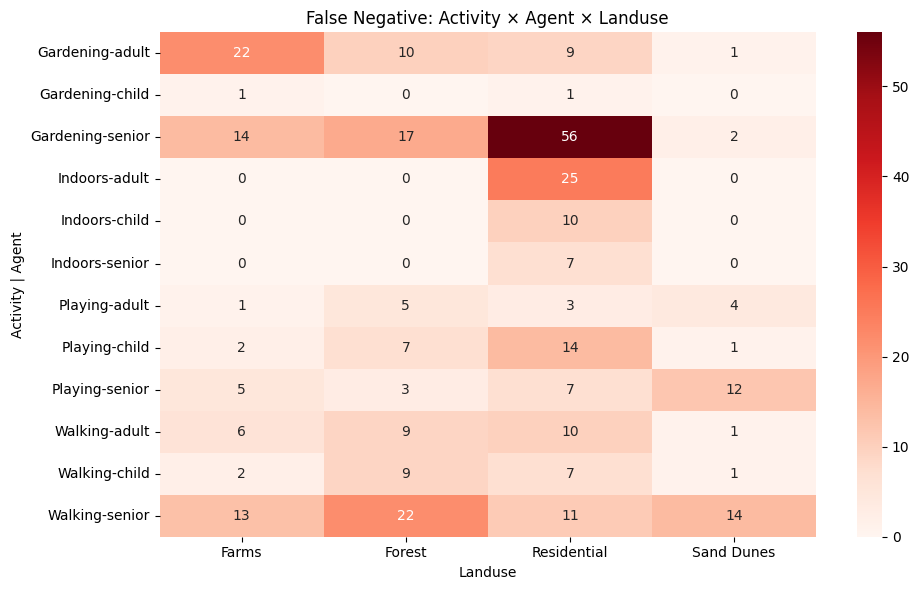

In [27]:
# Crosstab (False Negative)
fp_matrix = pd.crosstab(
    [false_negative["activity"], false_negative["agent"]],
    false_negative["patch-landuse"]
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fp_matrix, annot=True, fmt='d', cmap="Reds")
plt.title("False Negative: Activity × Agent × Landuse")
plt.ylabel("Activity | Agent")
plt.xlabel("Landuse")
plt.tight_layout()
plt.show()

Misclassification Analysis – False Negatives

1. **Indoors + Residential: Seniors (56), Adults (25), Children (10)**
    This group is generally expected to be low-risk, aligning with both real-world understanding and simulation logic. However, rare events (e.g., tick introduction via pets or clothes) were deliberately included in the ABM to simulate realism. Because such events are infrequent, the model fails to learn these subtle patterns and consistently underestimates the risk in these scenarios.

2. **Gardening + Residential or Farms: Seniors – Farms (14), Forest (17), Residential (56)**
    Gardening in Farms and Forests is a well-known high-risk activity for tick exposure. Despite this, the model frequently misclassifies these as low-risk. Two key factors may contribute:
    a. Underrepresentation of specific subgroups (e.g., senior gardeners in farms) in the training data.
    b. Data ambiguity, especially where activities labeled as “Other” or “Unknown” were reassigned based on land use, introducing potential noise and blurring distinctions between actual and inferred behavior.
3. **Walking + Forest or Farms: Adult (9), Child (9), Senior (22)**
    Walking in natural areas like forests and farms is risky, but context matters. The model may struggle to differentiate between low-risk walking (e.g., along urban edges or for short durations) and high-risk walking (e.g., through dense vegetation). Without finer-grained features like duration, route type, or depth into forested areas, this confusion leads to false negatives in genuinely high-risk cases.